In [1]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from data.load_dataset import load_dataset
from data.merge_dataset import merge_dataset
from data.feature_engineering import *
from model.inference import save_csv
from model.feature_select import select_features
from model.data_split import split_features_and_target
from model.model_train import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import os
import wandb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
match torch.cuda.is_available():
    case True: device = "cuda"
    case _: device = "cpu"

device

'cuda'

In [4]:
train_data, test_data, sample_submission, interest_data, subway_data, school_data, park_data = load_dataset()
# 기존 데이터에 새로운 feature들을 병합한 데이터프레임 불러오기
train_data, test_data = merge_dataset(train_data, test_data, interest_data, subway_data, school_data, park_data)

### 3. Data Preprocessing

# 위치 중복도 낮은 행 삭제
groups = train_data.groupby(["latitude", "longitude"])["index"].count()
conditioned_groups_index = groups[(groups >= 2) & (groups <= 5)].index # 이 범위를 파라미터로 조정하는걸로
small_groups = train_data[
    train_data["latitude"].isin(conditioned_groups_index.get_level_values(0)) &
    train_data["longitude"].isin(conditioned_groups_index.get_level_values(1))
]
train_data.drop(small_groups.index, axis=0, inplace=True)

# built_year > 2024 행 삭제
train_data = train_data[train_data["built_year"] < 2024]
train_data.reset_index(drop=True, inplace=True)

# log 변환
train_data, test_data = apply_log_transformation(train_data, test_data)

train_data["contract_year"] = train_data["contract_year_month"] // 100
train_data["contract_month"] = train_data["contract_year_month"] % 100
test_data["contract_year"] = test_data["contract_year_month"] // 100
test_data["contract_month"] = test_data["contract_year_month"] % 100


/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [5]:
train_data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', 'interest_rate', 'nearest_subway_distance',
       'nearest_subway_latitude', 'nearest_subway_longitude',
       'nearest_school_distance', 'nearest_school_latitude',
       'nearest_school_longitude', 'nearest_park_distance',
       'nearest_park_latitude', 'nearest_park_longitude', 'nearest_subway_num',
       'nearest_school_num', 'nearest_park_num',
       'num_of_subways_within_radius', 'num_of_schools_within_radius',
       'num_of_parks_within_radius', 'park', 'region',
       'nearest_leader_distance', 'nearest_leader_latitude',
       'nearest_leader_longitude', 'log_deposit', 'log_area_m2',
       'log_subway_distance', 'log_school_distance', 'log_park_distance',
       'log_leader_distance', 'contract_year', 'contract_month'],
      dtype='object')

In [6]:
selected_cols = [
    "area_m2",
    "built_year",
    "latitude",
    "longitude",
    "log_leader_distance",
    "log_subway_distance",
    # "log_school_distance",
    "log_park_distance",
    # "contract_year_month",
    "num_of_subways_within_radius",
    "park",
    "region",
    # 추가 변수
    # "interest_rate",
    # "num_of_schools_within_radius",
    # "num_of_parks_within_radius",
    # "contract_type",
    "contract_year",
    "contract_month"
]

In [7]:
X_train, y_train = train_data[selected_cols], train_data["deposit"]
X_test = test_data[selected_cols]
log_y_train = train_data["log_deposit"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.fit_transform(X_test)

# 다항식 변환 적용 (2차 다항식)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# 1. 데이터 불러오기
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)
X_val = torch.tensor(X_valid, dtype=torch.float32, device=device)
y_val = torch.tensor(y_valid.values, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

# 데이터로더 설정
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [8]:
X_train.shape

torch.Size([1432100, 90])

In [9]:
# 2. 모델 정의
input_size = X_train.shape[1]

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.softplus(self.fc3(x))
        return out

In [10]:
# 5. 모델 학습

# 3. 모델 인스턴스 생성
model = SimpleModel()
model.to(device)

# 가중치 초기화
for layer in model.children():
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)

# 4. 손실 함수와 옵티마이저 정의
criterion = nn.L1Loss()  # Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

# 학습 과정
num_epochs = 1000
loss_df = []
for epoch in range(num_epochs): # tqdm(range(num_epochs), desc="💃Total Epoch🕺"):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader: # tqdm(train_loader, desc=f"✨Epoch {epoch+1}✨:", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    scheduler.step(average_loss)
    print(f'✨Epoch [{epoch+1}/{num_epochs}]✨ Train Loss: {average_loss:.4f}', end=', ')

    # 검증 과정
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs).squeeze()
            val_loss = criterion(outputs, targets)
            val_epoch_loss += val_loss.item()

    average_val_loss = val_epoch_loss / len(val_loader)

    # # NaN 예외 처리
    # if math.isnan(average_val_loss):
    #     print('Validation Loss is NaN. Skipping this epoch.')
    #     continue
    
    print(f'Valid Loss: {average_val_loss:.4f}')

     # 조기 종료 조건 체크
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0  # 성능이 개선된 경우, 카운터를 리셋
    else:
        epochs_no_improve += 1  # 성능이 개선되지 않으면 카운터 증가

    # 설정한 patience를 초과하면 학습 중단
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
        break

    # 손실 기록
    loss_df.append(average_val_loss)

✨Epoch [1/1000]✨ Train Loss: 13717.2605, Valid Loss: 8301.1433
✨Epoch [2/1000]✨ Train Loss: 9528.3588, Valid Loss: 7597.6892
✨Epoch [3/1000]✨ Train Loss: 9161.0799, Valid Loss: 7294.5632
✨Epoch [4/1000]✨ Train Loss: 8985.3001, Valid Loss: 7117.0937
✨Epoch [5/1000]✨ Train Loss: 8880.7049, Valid Loss: 6971.8729
✨Epoch [6/1000]✨ Train Loss: 8806.2016, Valid Loss: 6875.3718
✨Epoch [7/1000]✨ Train Loss: 8747.3757, Valid Loss: 6802.9579
✨Epoch [8/1000]✨ Train Loss: 8689.8046, Valid Loss: 6741.1292
✨Epoch [9/1000]✨ Train Loss: 8665.7524, Valid Loss: 6685.2559
✨Epoch [10/1000]✨ Train Loss: 8648.4345, Valid Loss: 6663.3957
✨Epoch [11/1000]✨ Train Loss: 8617.4442, Valid Loss: 6619.5363
✨Epoch [12/1000]✨ Train Loss: 8596.2311, Valid Loss: 6613.3732
✨Epoch [13/1000]✨ Train Loss: 8576.5614, Valid Loss: 6607.4966
✨Epoch [14/1000]✨ Train Loss: 8556.3506, Valid Loss: 6570.1771
✨Epoch [15/1000]✨ Train Loss: 8538.2467, Valid Loss: 6534.1584
✨Epoch [16/1000]✨ Train Loss: 8523.4370, Valid Loss: 6558.3122


KeyboardInterrupt: 

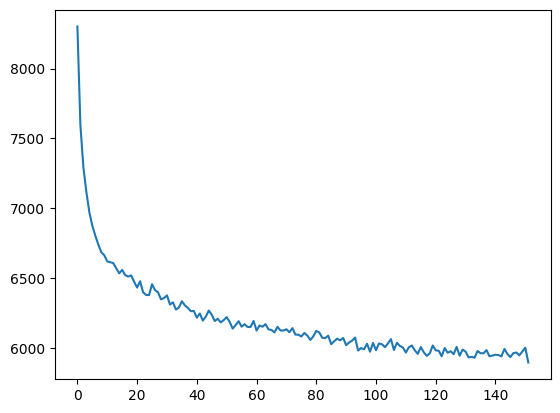

In [11]:
plt.plot(loss_df)

In [12]:
# 6. 예측 수행 및 배치 단위로 MAE 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
print(y_pred)

tensor([23780.9336, 12138.3945,  7966.1367,  ..., 56780.2461, 49703.6250,
        49818.6328], device='cuda:0')


<Axes: ylabel='Count'>

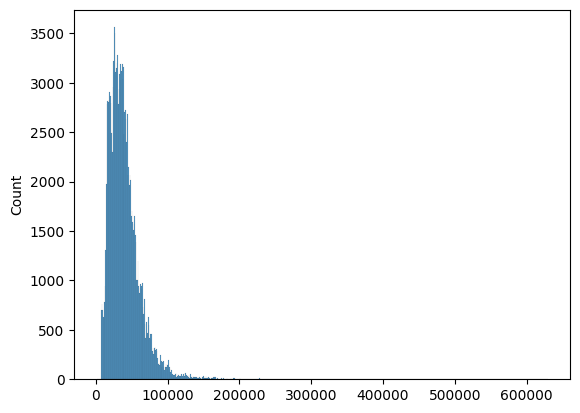

In [13]:
import seaborn as sns

y_pred = y_pred.cpu()
y_pred = pd.Series(y_pred)
sns.histplot(y_pred)

In [15]:
sample_submission["deposit"] = y_pred
sample_submission.to_csv("output.csv", index=False)

In [14]:
y_pred.describe()

count    150172.000000
mean      39962.871094
std       22668.414062
min        1665.759766
25%       24972.675781
50%       35711.996094
75%       49253.503906
max      629646.937500
dtype: float64

In [16]:
# 현재 모델 가중치를 저장
torch.save(model.state_dict(), 'model_checkpoint.pth') # epoch 152에서 중단

# # 모델 인스턴스 생성 후 가중치 로드
# model.load_state_dict(torch.load('model_checkpoint.pth'))